In [3]:
%run BinominalRiskPy.ipynb

,0.01,0.02,0.05,0.1,0.2,0.5
100,2.683,2.500,2.236,2.000,1.732,1.155
300,2.887,2.694,2.425,2.145,1.877,1.343
1000,3.054,2.864,2.546,2.294,2.000,1.414
3000,3.184,3.000,2.670,2.401,2.095,1.511
10000,3.290,3.077,2.770,2.496,2.183,1.633
30000,3.357,3.144,2.828,2.556,2.240,1.715
100000,3.411,3.206,2.889,2.638,2.324,1.747
300000,3.487,3.273,2.958,2.684,2.375,1.817
1000000,3.530,3.309,3.000,2.734,2.438,1.890
3000000,3.560,3.352,3.040,2.782,2.474,1.937


## Compute type 1 error

### Bayesian

In [67]:
bayesian_h0 = {0.8: None, 0.9: None, 0.95: None, 0.99: None, 0.995: None, 0.997:None, 0.999: None}

In [65]:
for thresh in bayesian_h0:
    if bayesian_h0[thresh] is not None:
        continue
    bayesian_f = Bayesian(thresh=thresh)
    bayesian_thresholds[thresh] = stochastic_process_simulation(bayesian_f, 10000, m=500)
    risk_dict, rejection_states, q = bayesian_thresholds[thresh]
    print(sum(risk_dict.values()), sum([i[1] for i in q.serialize()]), 
          sum([sum(risk_dict.values()), sum([i[1] for i in q.serialize()])]))

/anaconda/envs/ml_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in lbeta(x + u, N - x + v) : Interrupted

  warnings.warn(x, RRuntimeWarning)
/anaconda/envs/ml_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/anaconda/envs/ml_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: There were 50 or more warnings (use warnings() to see the first 50)
  warnings.warn(x, RRuntimeWarning)
/anaconda/envs/ml_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


KeyboardInterrupt: 

0.997 close to 4.3%

### BRAVO

In [68]:
alpha0 = 0.05
p0 = 0.55
bravo_alpha_h0 = {float(i): None for i in np.linspace(0.01, 0.1, 10)}
bravo_p_h0 = {float(i): None for i in np.linspace(0.51, 0.71, 10)}

for alpha in bravo_alpha_h0:
    bravo_f = BRAVO(p0, alpha)
    bravo_alpha_h0[alpha] = stochastic_process_simulation(bravo_f, 10000, m=500)
    risk_dict, rejection_states, q = bravo_alpha_h0[alpha]
    print(sum(risk_dict.values()), sum([i[1] for i in q.serialize()]), 
          sum([sum(risk_dict.values()), sum([i[1] for i in q.serialize()])]))
print("----------------------------------------")
for p in bravo_p_h0:
    bravo_f = BRAVO(p, alpha0)
    bravo_p_h0[p] = stochastic_process_simulation(bravo_f, 10000, m=500)
    risk_dict, rejection_states, q = bravo_p_h0[p]
    print(sum(risk_dict.values()), sum([i[1] for i in q.serialize()]), 
          sum([sum(risk_dict.values()), sum([i[1] for i in q.serialize()])]))

0.002315491200350923 0.9976845087996492 1.0000000000000002
0.006885500346955911 0.9931144996530442 1.0000000000000002
0.012685402907695108 0.9873145970923046 0.9999999999999998


KeyboardInterrupt: 

alpha = 0.7 close to 0.43

### Clip Audit

In [ ]:
alpha0 = 0.05
n0 = 10000

clip_alpha_h0 = {float(i): None for i in Clip.betas.columns}
clip_n_h0 = {float(i): None for i in Clip.betas.index}

for alpha in clip_alpha_h0:
    clip_f = Clip(n0, alpha)
    bravo_alpha_h0[alpha] = stochastic_process_simulation(clip_f, 10000, m=500)
    risk_dict, rejection_states, q = bravo_alpha_h0[alpha]
    print(sum(risk_dict.values()), sum([i[1] for i in q.serialize()]), 
      sum([sum(risk_dict.values()), sum([i[1] for i in q.serialize()])]))

alpha = 0.05 makes 4%

## Include Power and average

In [4]:
n = 10000
m = 500
p_h0 = 0.5
ps = [0.52, 0.55, 0.6, 0.7]

In [53]:
n = 10000
m = 1000
p_h0 = 0.5
ps = [0.52, 0.55, 0.6, 0.7]

In [54]:
def rejection_probability(audit_method, n, m, p, *args, **kwargs):
    audit_f = audit_method(*args, **kwargs)
    return sum(stochastic_process_simulation(audit_f, n, m=m, p=p)[0].velues())

def compute_full_probs(audit, ps, params, n, m, progression=False, *args, **kwargs):    
    for key in params: break
    params = params[key]
    
    audit_alt = {p: {float(i): None for i in params} for p in ps}
    audit_alt_power = {p: {float(i): None for i in params} for p in ps}

    for p in ps:
        if progression: print(f"p = {p}")
        for param in audit_alt[p]:
            if progression: print(f"    {key} = {param}")
            
            kwargs[key] = param
            audit_f = audit(*args, **kwargs)
            del kwargs[key]
            
            audit_alt[p][param] = stochastic_process_simulation(audit_f, n, m=m, p=p, progression=progression)
            reject_dict, rejection_states, q = audit_alt[p][param]
            power = sum(reject_dict.values())
            audit_alt_power[p][param] = power

            
    
    audit_h0_type1 = {float(i): None for i in params}
    for param in params:
        if progression: print(f"{key} = {param}")
    
        kwargs[key] = param
#         print(args, kwargs)
        audit_f = audit(*args, **kwargs)
        del kwargs[key]
        
#         print(n, m, p_h0)
        audit_h0_type1[param] = stochastic_process_simulation(audit_f, n, m=m, p=p_h0, progression=progression)
        reject_dict, rejection_states, q = audit_h0_type1[param]
        risk = sum(reject_dict.values())
#         print(risk, reject_dict)
        audit_h0_type1[param] = risk
        
    return audit_h0_type1, audit_alt_power, audit_alt

### Bayesian

In [55]:
thresholds = np.linspace(0.90, 1, 20)

bayesian_type1, bayesian_power, bayesian_alt = compute_full_probs(Bayesian, ps, {"thresh": thresholds}, n, m)


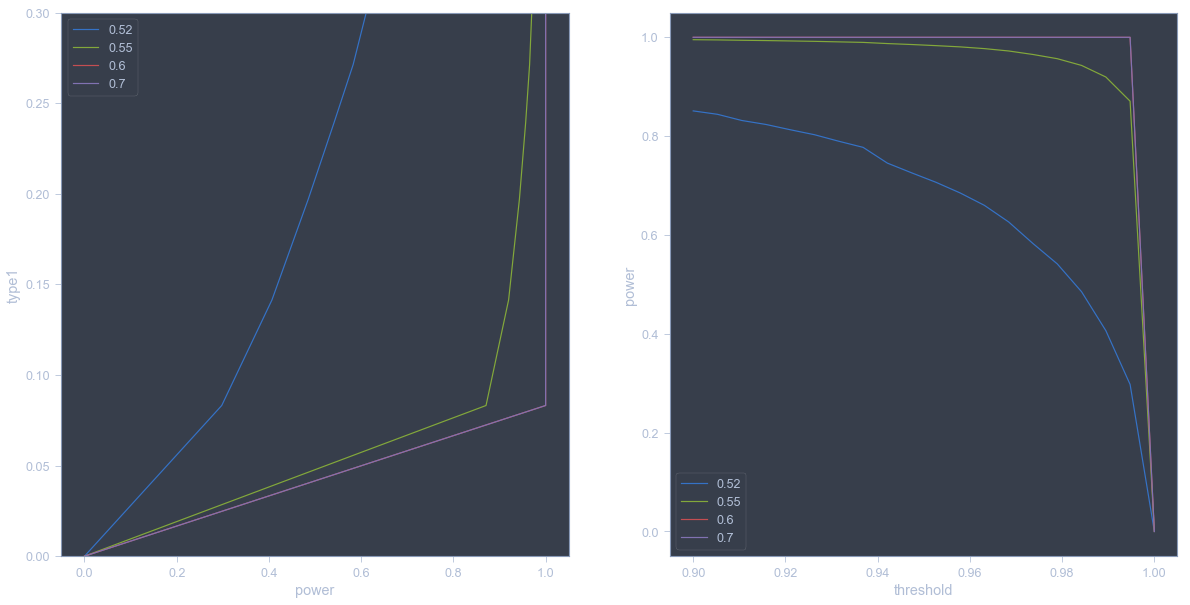

In [56]:
plt.figure(figsize=[20, 10])
plt.subplot(1, 2, 1)

for p in ps:
    plt.plot(bayesian_power[p].values(), bayesian_type1.values(), label=str(p))
plt.xlabel("power")
plt.ylim([0, 0.3])
plt.ylabel("type1")
plt.legend()

plt.subplot(1, 2, 2)
for p in ps:
    plt.plot(bayesian_power[p].keys(), bayesian_power[p].values(), label=str(p))
plt.xlabel("threshold")
plt.ylabel("power")
plt.legend()

### BRAVO

In [57]:
p_r = 0.55
alphas = np.linspace(0.1, 0.4, 20)

bravo_type1, bravo_power, bravo_alt = compute_full_probs(BRAVO, ps, {"alpha": alphas}, n, m, p=p_r)

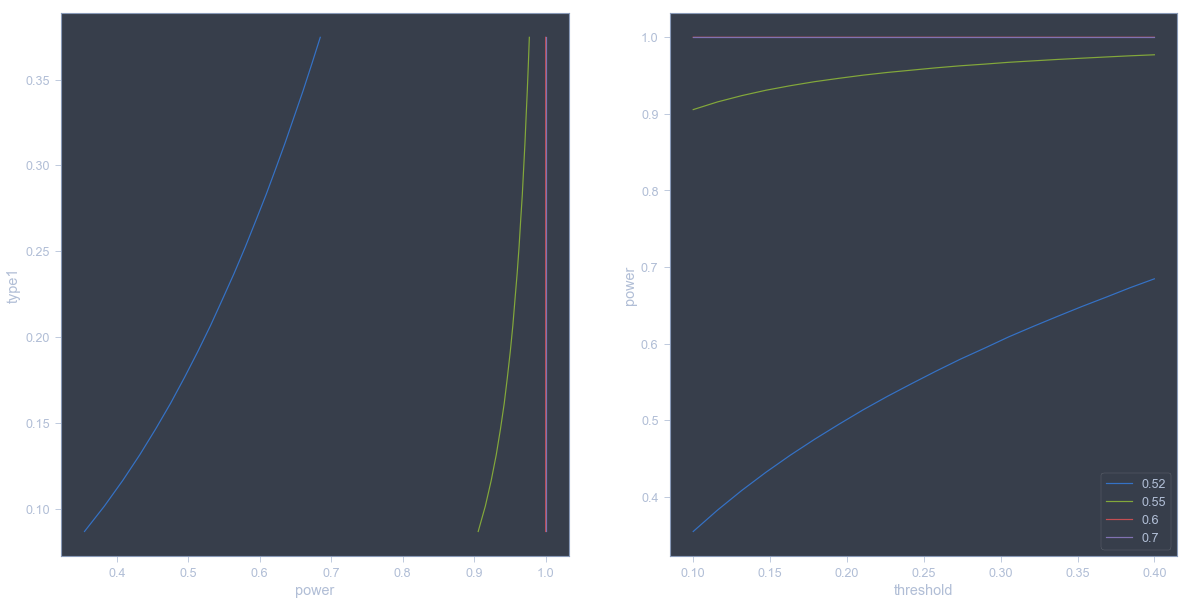

In [58]:
plt.figure(figsize=[20, 10])
plt.subplot(1, 2, 1)

for p in ps:
    plt.plot(bravo_power[p].values(), bravo_type1.values())
plt.xlabel("power")
plt.ylabel("type1")

plt.subplot(1, 2, 2)
for p in ps:
    plt.plot(bravo_power[p].keys(), bravo_power[p].values(), label=str(p))
plt.xlabel("threshold")
plt.ylabel("power")
plt.legend()